In [1]:
#from docopt import docopt
import numpy as np
import matplotlib.pyplot as plt
# Extract Features from a trained net via forward pass
import os
import sys
import tables as tb
import h5py as h5
from scipy import stats 
import subprocess as sub
from sklearn.metrics import mean_squared_error as mse
import collections
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import RandomizedPCA

%matplotlib inline
plt.style.use('ggplot')

##### Important Notes for AE training ###
## AE training with CT requires ADAGRAD/SGD solver, and properly scaled input [0,1] or linear output units
## Code layer could be linear or sigmoid --> sigmoid may help later with multimodal combinations.. 
## T106 is a working example ##
## Sparisity doesn't help (probably due to no strong spatial correlations)## 

#ADNI_016_S_4583_MR_MT1__GradWarp__N3m_Br_20120402170636723_S145150_I294869.n4correct.linear_antsRegistration.cutneckapplyautocrop.beastnormalize

In [2]:
def plot_from_logs(train_file, valid_file, log_title):
    '''
    Training Log Header:
    #Iters Seconds TrainingLoss LearningRate

    Valid Log Header:
    #Iters Seconds TestAccuracy TestLoss

    :param train_file:
    :param valid_file:
    :return:
    '''
    #tX = np.loadtxt(train_file, skiprows=1)    
    #vX = np.loadtxt(valid_file, skiprows=1)
    tX = np.genfromtxt(train_file, dtype=float, delimiter=',',skip_header=1)     
    vX = np.genfromtxt(valid_file, dtype=float, delimiter=',',skip_header=1) 
    
    t_iters = tX[:, 0]
    v_iters = vX[:, 0]
    seconds = tX[:, 1]

    #t_iters_lpf = tX[:, 3]
    #for i in np.arange(1,len(t_iter),1):
    #    t_iters_lpf[i] =  0.5*t_iters_lpf[i-1] + 0.5*t_iters_lpf[i]
    
    # Training loss and validation accuracy:    
    #plt.subplot(211)    
    p1, = plt.plot(t_iters, tX[:, 3], '-o',  label="Training Error")
    #p1, = plt.plot(t_iters, t_iters_lpf, '-o',  label="Training Loss")
    p2, = plt.plot(v_iters, vX[:, 3], '-d',linewidth=2, label="Validation Error")
    plt.xlabel('Iterations')
    plt.ylabel('Loss/Accuracy')
    plt.title(log_title)
    plt.legend()
    #plt.xlim([20000,40000])
    #plt.ylim([0,5000])
    #plt.legend(bbox_to_anchor=(0.,1.02, 1., 0.102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    
    # Learning rate:
    #plt.subplot(212)
    #p3, = plt.plot(t_iters, tX[:, 2], label="Learning Rate: " + log_title)
    #plt.xlabel('Iterations')
    #plt.ylabel('Learning Rate')
    #plt.legend(loc=1)
    #plt.ylim([0,0.01])
    #plt.grid()

In [3]:
#Run the process_caffe_logs.sh from here
process_logs_script = '/projects/nikhil/ADNI_prediction/models/caffe_models/ff/process_caffe_logs.sh'
start_fold = 1
n_folds = 1
modality = 'CT'
snap_start = 2000
snap_interval = 2000
tid_start = 2001
n_intervals = 7

tid_series = np.arange(tid_start,tid_start+n_intervals,1)
snapshot_series = np.arange(snap_start,snap_start+snap_interval*n_intervals,snap_interval)

process_logs = True
start_interval = 0
if process_logs:
    for interval in np.arange(start_interval,n_intervals,1):    
        tid = tid_series[interval]
        snapshot_iter = snapshot_series[interval]
        sub.call([process_logs_script, str(modality), str(tid), str(start_fold), str(n_folds), str(snapshot_iter)])

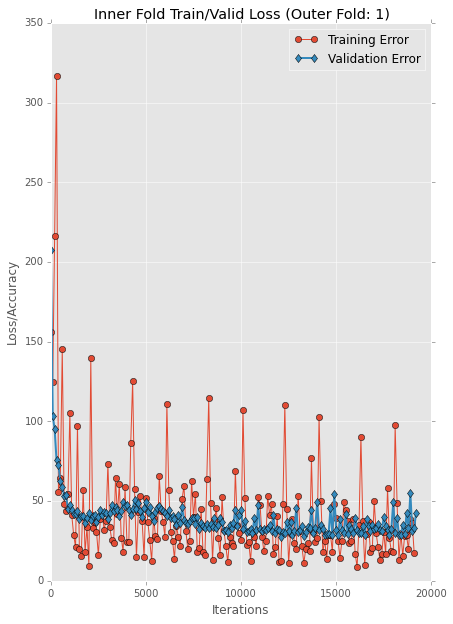

In [4]:
#plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)
baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/'
n_cols = 2
n_rows = (n_folds+1)/n_cols
tid = tid_series[n_intervals-1]
for lid in np.arange(start_fold,n_folds+1,1):  
    plt.subplot(n_rows,n_cols,lid)
    train_file = '{}OuterFold_{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'train',lid,modality,tid)
    valid_file = '{}OuterFold_{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'test',lid,modality,tid)
    log_title = 'Inner Fold Train/Valid Loss (Outer Fold: {})'.format(lid)
    plot_from_logs(train_file, valid_file, log_title)
    
plt.show()

In [5]:
import caffe

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X


def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0]).shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    code_layer = net.blobs[encoding_layer]
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))
    
    print 'X_out shape: {}'.format(X_out.shape)
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()
        
    print 'Extracting features from data...'
    print 'X_out.shape: {}'.format(X_out.shape)
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()

    return {'X_out':X_out, 'wt_dict':wt_dict}

In [12]:
#CV perf (Inner Loop)
baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir + 'caffe_input/' 
#input_data_dir_path = baseline_dir + 'encodings/' 
target_file = caffe_output_path + 'test_1'
#modality = 'CT'
innerLoop = True
outerLoop = False
use_encodings = False

tid_series = np.arange(tid_start,tid_start+n_intervals,1)
snapshot_series = np.arange(snap_start,snap_start+snap_interval*n_intervals,snap_interval)

batch_size = 256 

if start_interval == 0:
    CV_inner_perf_dict = collections.defaultdict(list) # {lid:[(tid1,snap1,mse1,r1,p1),(tid2,snap2,mse1,r1,p1),...]}
    print 'resetting perf dictionary'

actual_scores_list = []
# Try out various permutations of hyper-params on the inner loop
for lid in np.arange(start_fold,n_folds+1,1):
        
    fold_dir = '{}OuterFold_{}'.format(caffe_output_path,lid)
    sub.call(["cp", fold_dir+"/test_C688_innerFold.txt", fold_dir+"/test_C688.txt"])
    input_data_path = '{}CV_Exp4_ADNI1_ADAS13_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(input_data_dir_path,lid)
    #input_data_path = '{}CV_Exp4_ADNI1_ADAS13_AE_inner_train_fold_{}.h5'.format(input_data_dir_path,lid)

    if modality == 'HC':
        input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]
    elif modality == 'HC_CT':
        input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                       'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
    elif modality in ['HC_R_CT', 'R_HC_CT']:
        input_nodes = ['Fold_{}_X_{}'.format(lid,'R_HC'),
                       'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
    elif modality == 'CT':            
        input_nodes = ['Fold_{}_X_{}'.format(lid,'R_CT')]
    else:
        input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]

    if use_encodings:
        input_nodes = ['Fold_{}_X_{}'.format(lid,'encode')]
        
    labels_dataset_name = 'Fold_{}_y'.format(lid)
    label_dataset = h5.File(input_data_path)                
    actual_scores = label_dataset[labels_dataset_name][:]
    label_dataset.close()
    actual_scores_list.append(actual_scores)
    
    encodings_list = []    
    compute_tsn = False 
    for interval in np.arange(start_interval,n_intervals,1):
        tid = tid_series[interval]
        snapshot_iter = snapshot_series[interval]
        
        model_file = '{}OuterFold_{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,lid,snapshot_iter,modality,tid)    
        net_file = '{}OuterFold_{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,lid,modality,tid)
    
        print model_file, net_file
    
        #TSNE computations
        if compute_tsn:
            encoding_layer = 'code'
            weight_layers = ['code']      
            results = extract_features(net_file, model_file, input_data_path, input_nodes, batch_size, encoding_layer, weight_layers)
            predicted_scores = results['X_out'].ravel()  
            wts = results['wt_dict']
            encodings_list.append(predicted_scores)
        
        # Simple output predictions (classification / regression probs)
        else:
            encoding_layer = 'clas'
            weight_layers = ['clas']      
            results = extract_features(net_file, model_file, input_data_path, input_nodes, batch_size, encoding_layer, weight_layers)
            predicted_scores = results['X_out'].ravel()  
            wts = results['wt_dict']
            _r = stats.pearsonr(predicted_scores,actual_scores)[0]
            _p = stats.pearsonr(predicted_scores,actual_scores)[1]
            _mse = mse(predicted_scores,actual_scores)

            CV_inner_perf_dict[lid].append((tid, snapshot_iter, _mse, _r, _p, wts))
        

resetting perf dictionary
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/_iter_2000.caffemodel_CT_T2001 /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/net_partition.prototxt_CT_T2001
('Fold_1_X_R_CT', <caffe._caffe.Blob object at 0x7f1b75f6ed70>)
('Fold_1_y', <caffe._caffe.Blob object at 0x7f1bf06ce050>)
X_out shape: (6133, 1)
Extracting features from data...
X_out.shape: (6133, 1)
. . . . . . . . . . . . . . . . . . . . . . . . /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/_iter_4000.caffemodel_CT_T2002 /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/net_partition.prototxt_CT_T2002
('Fold_1_X_R_CT', <caffe._caffe.Blob object at 0x7f1bf06ce050>)
('Fold_1_y', <caffe._caffe.Blob object at 0x7f1b9a9239b0>)
X_out shape: (6133, 1)
Extracting features from data...
X_out.shape: (6133, 1)
. . . . . . . . . . . . . . . . . . . . . . . . /project

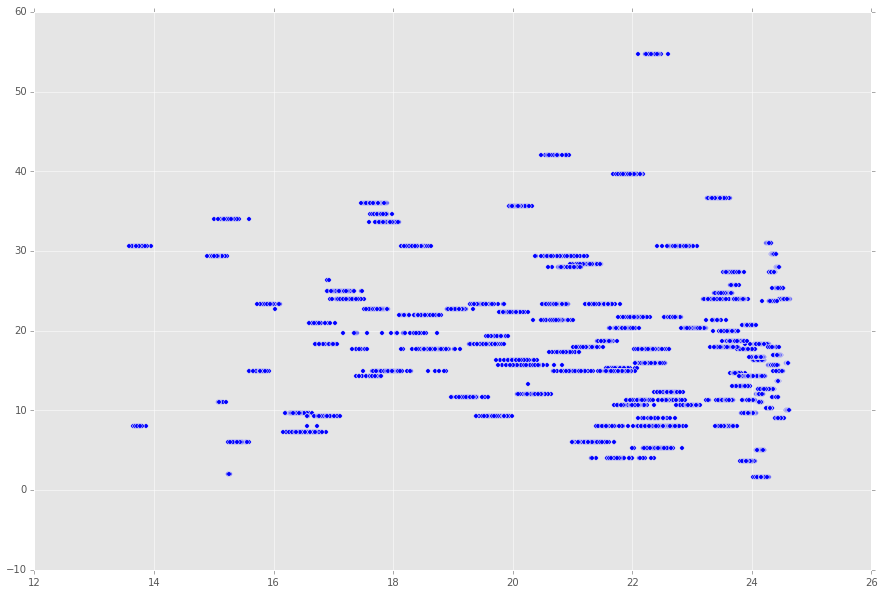

In [13]:
plt.scatter(predicted_scores,actual_scores)

fold:1, best_arg: 5, tid:2006


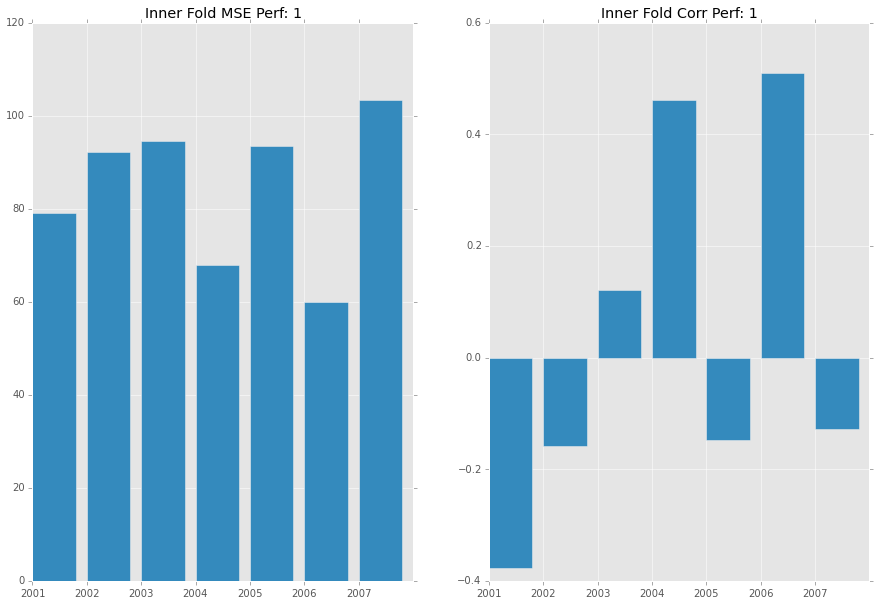

In [8]:
plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)
x_plt = np.arange(n_intervals)
config_dict_IF = {}
for lid in np.arange(start_fold,n_folds+1,1):
    plt.subplot(n_folds,2,2*lid-1)
    plt.title('Inner Fold MSE Perf: {}'.format(lid))
    plt.bar(x_plt,zip(*CV_inner_perf_dict[lid])[2])
    plt.xticks(x_plt,zip(*CV_inner_perf_dict[lid])[0])
    plt.subplot(n_folds,2,2*lid)
    plt.title('Inner Fold Corr Perf: {}'.format(lid))
    plt.bar(x_plt,zip(*CV_inner_perf_dict[lid])[3])
    plt.xticks(x_plt,zip(*CV_inner_perf_dict[lid])[0])  
    best_arg= np.argmax(np.divide(zip(*CV_inner_perf_dict[lid])[3],zip(*CV_inner_perf_dict[lid])[2]))
    #best_arg= np.argmin(zip(*CV_inner_perf_dict[lid])[2])
    #best_arg= np.argmax(zip(*CV_inner_perf_dict[lid])[3])
    config_dict_IF[lid]=[zip(*CV_inner_perf_dict[lid])[1][best_arg],zip(*CV_inner_perf_dict[lid])[0][best_arg]]
    print 'fold:{}, best_arg: {}, tid:{}'.format(lid, best_arg, zip(*CV_inner_perf_dict[lid])[0][best_arg])
#     print 'MSE'
#     print np.argsort(zip(*CV_inner_perf_dict[lid])[2])
#     print 'Corr'
#     print np.argsort(zip(*CV_inner_perf_dict[lid])[3])
#     print 'ratio'
#     print np.argmax(np.divide(zip(*CV_inner_perf_dict[lid])[3],zip(*CV_inner_perf_dict[lid])[2]))

In [ ]:
config_dict[5] = [30000,425]
config_dict[6] = [30000,425]
config_dict[7] = [30000,425]
config_dict[8] = [30000,425]
config_dict

In [ ]:
#Visualize the weights
lid = 1
CV_singlefold_perf = CV_inner_perf_dict[lid]
#rows = len(CV_singlefold_perf)
cols = len(CV_singlefold_perf[0][5].keys())
for snap in CV_singlefold_perf:
    wt_dict = snap[5]
    plt.figure()
    for k, key in enumerate(wt_dict.keys()):
        plt.subplot(1,cols,k+1)
        plt.imshow(wt_dict[key],interpolation="nearest",aspect='auto')
        plt.title(key)
        plt.colorbar()
    plt.tight_layout()
        

In [9]:
 # Outer Loop performance 
X_out = []
labels = []
CV_r = []
CV_MSE = []
#modality = 'CT'
#n_folds = 10
encoding_layer = 'clas'
weight_layers = ['clas']
batch_size = 256
snapshot_iter = 15000
tid = 103
compute_OF_perf = False
compute_tsn = False
encodings_list = []


# HC_CT_1
# config_dict = {1:['20000','1007'],2:['18000','1006'],3:['10000','1002'],4:['50000','1006'],5:['14000','1004'],
#                6:['12000','1003'],7:['16000','1005'],8:['12000','1003'],9:['8000','1001'],10:['14000','1004']}

# HC_CT_2
#config_dict = {1:['12000','273'],2:['12000','273'],3:['12000','273'],4:['12000','273'],5:['12000','273'],
#               6:['12000','273'],7:['12000','273'],8:['12000','273'],9:['16000','274'],10:['20000','275']}

# HC_CT_3
#config_dict = {1:['12000','273'],2:['12000','273'],3:['12000','273'],4:['12000','273'],5:['12000','273'],
#               6:['12000','273'],7:['14000','357'],8:['14000','357'],9:['12000','356'],10:['16000','358']}

#HC_CT_4
#config_dict = {1:['12000','273'],2:['12000','273'],3:['12000','273'],4:['12000','273'],5:['12000','273'],
#               6:['34000','427'],7:['4000','432'],8:['30000','425'],9:['12000','356'],10:['16000','358']}

#HC_CT_5
#config_dict = {1: ['24000', '484'], 2: ['22000', '482'], 3: ['12000', '273'], 4: ['30000', '490'],5:['12000','273'],
#               6:['34000','427'],7:['4000','432'],8:['30000','425'],9:['12000','356'],10:['16000','358']}



# HC
#config_dict = {1:['28000','357'],2:['28000','357'],3:['14000','350'],4:['14000','350'],5:['12000','349'],
#               6:['16000','351'],7:['20000','353'],8:['14000','350'],9:['12000','349'],10:['24000','355']}

baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir  
target_file = caffe_output_path + 'test_1'

do_sweep = True
if do_sweep:
    CV_outer_perf_dict = collections.defaultdict(list)
    
for lid in np.arange(start_fold,n_folds+1,1):
#for lid in np.arange(1,10+1,1):
    
    #snapshot_iter = config_dict[lid][0]
    #tid = config_dict[lid][1]     
     
    model_file = '{}OuterFold_{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,lid,snapshot_iter,modality,tid)    
    net_file = '{}OuterFold_{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,lid,modality,tid)
    
    print model_file, net_file
    print input_data_dir_path
    
    fold_dir = '{}OuterFold_{}'.format(caffe_output_path,lid)
    print fold_dir+"/test_C688_outerFold.txt"
    sub.call(["cp", fold_dir+"/test_C688_outerFold.txt", fold_dir+"/test_C688.txt"])
    input_data_path = '{}CV_Exp4_ADNI1_ADAS13_NN_valid.h5'.format(input_data_dir_path)
    print input_data_path
    if modality == 'HC':
        input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]

    elif modality == 'HC_CT':            
        input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                       'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
    elif modality in ['HC_R_CT', 'R_HC_CT']:
        input_nodes = ['Fold_{}_X_{}'.format(lid,'R_HC'),
                       'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
    elif modality == 'CT':            
        input_nodes = ['Fold_{}_X_{}'.format(lid,'R_CT')]

    else:            
        input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]

    labels_dataset_name = 'Fold_{}_y'.format(lid)    
    actual_scores = load_data(input_data_path, labels_dataset_name)
    labels.append(actual_scores)
    
    start_interval = 0
    if do_sweep:
        #tid_start = 501
        #n_intervals = 25
        tid_series = np.arange(tid_start,tid_start+n_intervals,1)
        snapshot_series = np.arange(snap_start,snap_start+snap_interval*n_intervals,snap_interval)
        for interval in np.arange(start_interval,n_intervals,1):
            tid = tid_series[interval]
            snapshot_iter = snapshot_series[interval]

            model_file = '{}OuterFold_{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,lid,snapshot_iter,modality,tid)    
            net_file = '{}OuterFold_{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,lid,modality,tid)

            print model_file, net_file
        
            results = extract_features(net_file, model_file, input_data_path, input_nodes, batch_size, encoding_layer, weight_layers)
            predicted_scores = results['X_out'].ravel()  
            wts = results['wt_dict']
            _r = stats.pearsonr(predicted_scores,actual_scores)[0]
            _p = stats.pearsonr(predicted_scores,actual_scores)[1]
            _mse = mse(predicted_scores,actual_scores)

            CV_outer_perf_dict[lid].append((tid, snapshot_iter, _mse, _r, _p, wts))
            
    else:
        results = extract_features(net_file, model_file, target_file, input_data_path, input_nodes, batch_size, encoding_layer)        
    
        if compute_OF_perf:
            predicted_scores = results['X_out'].ravel()
            X_out.append(predicted_scores)                
            CV_r.append(stats.pearsonr(predicted_scores,actual_scores))
            CV_MSE.append(mse(predicted_scores,actual_scores))
            print zip(*CV_r)[0]
            print CV_MSE
            print 'r mean: {}, median: {}'.format(np.mean(zip(*CV_r)[0]), np.median(zip(*CV_r)[0]))
            print 'MSE mean: {}, median: {}'.format(np.mean(CV_MSE),np.median(CV_MSE))
        
        if compute_tsn:
            encodings_list.append(results['X_out'])
    

    

/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/_iter_15000.caffemodel_CT_T103 /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/net_partition.prototxt_CT_T103
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/test_C688_outerFold.txt
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/_iter_2000.caffemodel_CT_T2001 /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output/OuterFold_1/net_partition.prototxt_CT_T2001
('Fold_1_X_R_CT', <caffe._caffe.Blob object at 0x7f1b75f6ef50>)
('Fold_1_y', <caffe._caffe.Blob object at 0x7f1b9a9df488>)
X_out shape: (69, 1)
Extracting features from data...
X_out.shape: (69, 1)
. /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_output

fold:1, best_arg: 5, tid:2006
best r: [0.61255442542364347]
best mse: [54.35434734031498]
r mean: 0.612554425424, median: 0.612554425424
MSE mean: 54.3543473403, median: 54.3543473403
{1: [12000, 2006]}


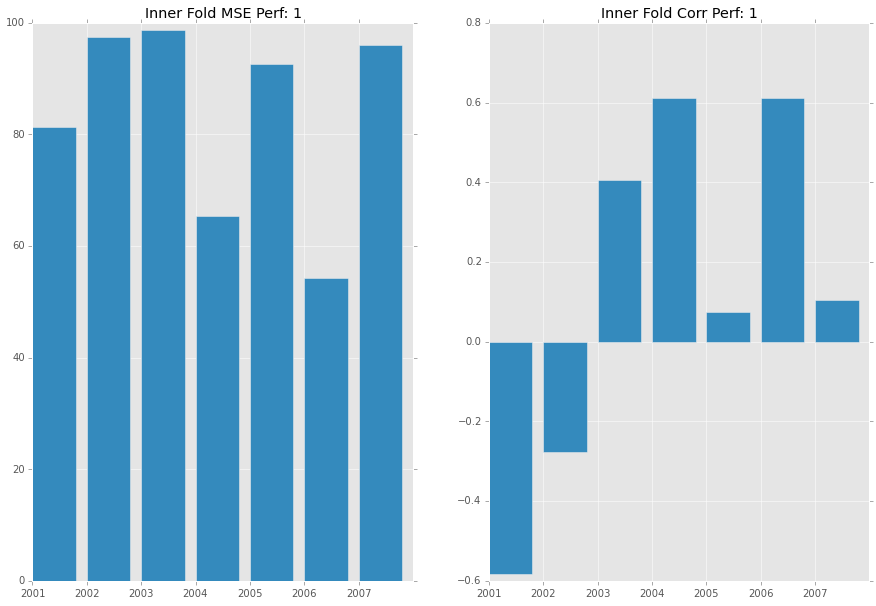

In [10]:
#Outer Fold Sweep Results
plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)
x_plt = np.arange(n_intervals)
config_dict = {}
best_r = []
best_MSE = []
for lid in np.arange(start_fold,n_folds+1,1):
    plt.subplot(n_folds,2,2*lid-1)
    plt.title('Inner Fold MSE Perf: {}'.format(lid))
    plt.bar(x_plt,zip(*CV_outer_perf_dict[lid])[2])
    plt.xticks(x_plt,zip(*CV_outer_perf_dict[lid])[0])
    plt.subplot(n_folds,2,2*lid)
    plt.title('Inner Fold Corr Perf: {}'.format(lid))
    plt.bar(x_plt,zip(*CV_outer_perf_dict[lid])[3])
    plt.xticks(x_plt,zip(*CV_outer_perf_dict[lid])[0])  
    #best_arg= np.argmax(np.divide(zip(*CV_outer_perf_dict[lid])[3],zip(*CV_outer_perf_dict[lid])[2]))
    best_arg= np.argmin(zip(*CV_outer_perf_dict[lid])[2])
    #best_arg= np.argmax(zip(*CV_outer_perf_dict[lid])[3])
    config_dict[lid]=[zip(*CV_outer_perf_dict[lid])[1][best_arg],zip(*CV_outer_perf_dict[lid])[0][best_arg]]
    print 'fold:{}, best_arg: {}, tid:{}'.format(lid, best_arg, zip(*CV_outer_perf_dict[lid])[0][best_arg])
    best_r.append(np.max(zip(*CV_outer_perf_dict[lid])[3]))
    best_MSE.append(np.min(zip(*CV_outer_perf_dict[lid])[2]))
    
print "best r: {}".format(best_r)
print "best mse: {}".format(best_MSE)
print 'r mean: {}, median: {}'.format(np.mean(best_r), np.median(best_r))
print 'MSE mean: {}, median: {}'.format(np.mean(best_MSE),np.median(best_MSE))
print config_dict


In [ ]:
Baseline:
. (0.70564435352460997, 0.517840973353631, 0.75702845615970893, 0.57635800708387785, 0.49296854472106943, 
   0.58159254481632194, 0.53256730147481623, 0.52497351620295696, 0.70665807771420519, 0.61430941277826534)
[42.925540240196284, 45.927271282413322, 43.810564638107031, 50.867308310065859, 70.244155137979007, 
 71.981000227888757, 43.820256622662917, 52.38125532116873, 40.127145044881381, 57.477544774939616]
r mean: 0.600994118783, median: 0.57897527595
MSE mean: 51.95620416, median: 48.3972897962



best r: [0.71852822563001306, 0.54086343391400649, 0.74536237155237639, 0.59804596854759018, 0.46272578408069615, 
         0.5025301563454686, 0.54073102946827734, 0.52466856358939906, 0.65288737693185528, 0.55377668517090561]
best mse: [38.983071803803867, 45.17609704232985, 44.752758534096564, 50.159636590082791, 73.532074658136835, 
           83.07227708065227, 47.229657642056104, 56.344916431843622, 47.869254562237565, 62.096947307649152]
r mean: 0.584011959523, median: 0.547320059542
MSE mean: 54.9216691653, median: 49.0144455762
{1: [24000, 484], 2: [22000, 482], 3: [30000, 490], 4: [30000, 490], 5: [23000, 483], 
 6: [27000, 487], 7: [20000, 480], 8: [29000, 489], 9: [27000, 487], 10: [28000, 488]}



HC_CT 270x
. (0.70564435352460997, 0.517840973353631, 0.75702845615970893, 0.57635800708387785, 0.49296854472106943,
   0.5376954938436832, 0.48469275690730868, 0.50654648086431198, 0.64422164877164378, 0.60756120427983062)
[42.925540240196284, 45.927271282413322, 43.810564638107031, 50.867308310065859, 70.244155137979007, 
 78.810656356828545, 48.535817260684063, 57.742215803029843, 46.338186606173444, 56.4457513000579]
0.583055791951
0.557026750464
49.7015627854

Exp4: L_HC 211 5k
. (0.60462401765723606, 0.48516305651935887, 0.24959465876281012, 0.39017872234583001)
[50.827044272878133, 48.904806466951371, 93.391479969897574, 66.99057283936699]
0.432390113821
0.437670889433
58.9088085561

Exp4: R_HC 211 5k
. (0.6031327824097501, 0.36131275236449889, 0.53915781971267374, 0.42567544978478572)
[51.009682560651065, 56.852986720453281, 66.095151707482444, 65.19981306389262]
0.482319701068
0.482416634749
61.0263998922

Exp4: HC 212 4k
. (0.70208465322357139, 0.44445200002560842, 0.49584358132033757, 0.48456502739299995)
[42.623114632823111, 52.904608107063311, 80.633272559622725, 61.914142257185382]
0.531736315491
0.490204304357
57.4093751821

Exp4: CT 213 15k
. (0.54462942906560918, 0.44392604691194432, 0.71259678795254378, 0.52201770696304184, 0.34023490109206944, 
   0.56434778963948051, 0.40455030947554121, 0.40736716839407533, 0.511641360302306, 0.51345523331359655)
[57.17106403989159, 59.734899705911488, 47.415485848399584, 57.709919583204282, 89.561353776105818, 
 73.972507443796388, 71.160120780169137, 64.915035366544799, 62.314143106030329, 66.190466451626889]
0.496476673311
0.512548296808
63.6145892363

Exp4: HC_CT 213 15k
. (0.6880639065288181, 0.45097163683076691, 0.54129149259811749, 0.50450467395562482)
[44.047074238322459, 55.093798716473927, 68.950144065576296, 58.077675582205551]
0.546207927478
0.522898083277
56.5857371493

Exp4: HC_CT 229 4k
X_out.shape: (69, 1)
. (0.68865185781824567, 0.50753060088608459, 0.54780128001224926, 0.50882834409340127)
[44.79202893057132, 49.399416677316609, 74.936976996164205, 61.31591400769566]
0.563203020702
0.528314812053
55.3576653425

Exp4: HC_CT 234 8k
. (0.71472924390022929, 0.45660924868338332, 0.55797803614934982, 0.47864568888641795, 0.3988855956336344, 
   0.34507597388259731, 0.51433447830675516, 0.47143017066268522, 0.63420026515618211, 0.58813383882376347)
[42.93349619696032, 50.344549719821096, 68.497102058826769, 61.668597180097422, 90.66542464682189, 
 98.793615885032509, 51.783040007857444, 56.380071881314784, 55.392331079684979, 60.201552190578631]
0.516002254008
0.496490083597
58.2908120359

-----------------------TanH-----------------------
Exp4: HC 260 20k
. (0.58120705447657073, 0.36063576038309864)
[56.350512583592831, 70.38380836692626]
0.47092140743
0.47092140743
63.3671604753

Exp4: CT 265 20k
. (0.59957895241028036, 0.46119623832155193)
[50.851896436470717, 52.776488329278365]
0.530387595366
0.530387595366
51.8141923829


--------


In [ ]:
len(encodings_list)

In [ ]:
# Plot tsne for the encodings
n_cols = 2
n_rows = (n_folds+1)/n_cols
tsne_interval = 5
for lid in np.arange(n_folds):    
    tsne = TSNE(n_components=2, random_state=0, init='pca')
    code = encodings_list[tsne_interval]['X_out']
    score = actual_scores_list[tsne_interval]
    proj = tsne.fit_transform(code.astype(float))
    plt.subplot(n_rows, n_cols, lid+1)
    plt.scatter(proj[:, 0], proj[:, 1], c=score, cmap='Reds', alpha=0.7,label=lid)
    plt.legend()
    plt.colorbar()



In [ ]:
-------------HC-CT --------------------
12k 349 [5,9]
. (0.56783685573014153, 0.25279325917021311, 0.62800597275738668, 0.48680247923631031, 0.66209961040981191, 
   0.58641423389175784, 0.51198829340124119, 0.60841003694372975, 0.48457154026419336, 0.44942246222720522)
[87.233519944483419, 127.15456735402975, 44.081091653206542, 67.762916847406302, 47.961849807741515, 
 68.746968010683446, 79.869476663940432, 85.854011951391641, 74.841598258096894, 81.569960899350335]
0.539912574566
77.355537461

14k 350 [3,4,8]
. (0.59831902328524778, 0.2999542269536965, 0.63408608657534038, 0.48920595568826747, 0.6607622020108872,
   0.60749883456207776, 0.53529162821586063, 0.61321728403425979, 0.47641516641915849, 0.45658382130394365)
[81.622553769498566, 122.18010430884672, 42.179480360881932, 66.426565528001035, 45.209057981698244, 
 58.323490538773299, 73.742549938373926, 84.418461764353168, 77.734339832301373, 75.605478203371902]
0.566805325751
74.6740140709

16k 351 [6]
. (0.61386065022339786, 0.34204982794479488, 0.62701238315629393, 0.48347575506510138, 0.65419080979498101, 
   0.61390559534730016, 0.55217962779772567, 0.60745836676167408, 0.4592854172821012, 0.45835688636221134)
[77.419564591162128, 115.98582444773851, 41.409077679175404, 66.304847247965554, 56.147726649163133, 
 53.219071165445548, 70.30662723379325, 83.554548817583481, 95.176887039121084, 71.87297359478336]
0.57981899728
71.0898004143

18k 352 []
. (0.61788644845424878, 0.3882475265651496, 0.61473750313125619, 0.47844306536980952, 0.64789754613207218,
   0.60661698901689254, 0.56183098321119718, 0.59988302082412959, 0.43545951715436082, 0.4582003543883017)
[74.343574113244287, 108.74242061371983, 41.964898003055666, 66.457467347049302, 49.57936369571641, 
 50.164738470936086, 67.202134127269474, 80.914967649085483, 88.606307497470169, 70.366343517516825]
0.580857002018
68.7842388224

20k 353 [7]
. (0.61711542188811341, 0.42744681196527046, 0.59912622064086651, 0.47895608774518234, 0.64573451434811624, 
   0.59020390233049791, 0.56231801784496682, 0.58960535818282833, 0.4164485723463604, 0.45715586701903238)
[70.349505859157901, 98.71747577576869, 43.325393318157701, 66.273390529069019, 48.02499870329482, 
 49.748370943584497, 65.802233997376149, 70.329804963972151, 87.469185720293623, 69.078829433042188]
0.575961688014
67.6761099811

22k 354 
. (0.61685574509642627, 0.46106240258794368, 0.58327351653950044, 0.48085282898987924, 0.64464380794439979, 
   0.5722321622909522, 0.55506522293979288, 0.58712742153175312, 0.38203725047012604, 0.4580553462408064)
[69.124426503473245, 91.862412816579948, 42.762004081203415, 65.898610469838403, 45.549725614319193, 
 50.270885979158848, 63.180157626495422, 72.880638466242672, 75.202426189796356, 68.673728236089033]
0.563648692615
67.286169353

24k 355 [10]
. (0.6189245315652665, 0.48969618072070548, 0.57784258415955136, 0.4827045185792983, 0.64422052048283907, 
   0.55473105804114053, 0.54975744151440009, 0.58015786035280581, 0.39645435921358857, 0.4606332845793808)
[69.020935879147018, 87.455917250078059, 43.135181028716858, 65.597573694618717, 53.596676535125567, 
 51.199746362193807, 63.673233850825241, 73.772734461254501, 84.562530586860788, 66.829320743738521]
0.552244249778
66.2134472192

26k 356 
. (0.62363584774562308, 0.51339196271929111, 0.57872444150762592, 0.4872436045047468, 0.64161555575685614,
   0.54100924378449444, 0.55109381806790003, 0.5814927348967488, 0.38580840187488891, 0.46089116504492822)
[66.921067007653235, 81.636218323665645, 42.915327525989689, 65.142485980803968, 46.579791391890652, 
 52.827476409876247, 64.091600356901353, 75.328153254529923, 75.939037284623794, 68.068642326437839]
0.546051530926
66.0317764942

28k 357 [1,2]
. (0.62892986258752548, 0.5290323894287019, 0.56512341840419611, 0.48605443618764471, 0.64512425279233099, 
   0.52959560027305908, 0.55449781395164066, 0.58342701469393354, 0.38398903925934186, 0.46086314294767022)
[67.421897459639993, 78.844096966934913, 47.316616290131201, 65.310089506637198, 50.641535035379398, 
 54.819347829667635, 63.265080443248074, 73.662703249496275, 74.262813945641653, 69.121718351379087]
0.542046707112
66.3659934831

-------------HC-CT --------------------
16k 325 ES fids[2,3,4]
. (0.66843540440751636, 0.57457391802396729, 0.61412909264203475, 0.52026693277630676, 0.59819493719671546, 
   0.60659875796637108, 0.51795145731541248, 0.58974545921792676, 0.38770791046812436, 0.46387859933379871)
[74.833272317617485, 72.346594133571458, 42.457876403983931, 64.603924727461191, 67.824357936331367, 
 49.5262324988038, 60.373097367421089, 90.182320092003096, 98.872740760634912, 81.201394170028919]
0.582159688621
70.085476035


-------------HC-CT --------------------
304 8k
. (0.55906373523029196, 0.29019126856871141, 0.6284637957253717, 0.60739800065842309, 0.58889635554553355, 
   0.60757955829367349, 0.46580606802765256, 0.57054336854857746, 0.4970758168298095, 0.49207676766196778)
[98.720798971026952, 116.16429432826479, 57.636414077760989, 71.770528297625489, 93.413291036602516, 
 64.616482038802133, 66.0794428024967, 108.27504892746316, 90.465999299784741, 92.321830392787035]
0.564803551889
91.3939148463

305 10k
. (0.60374083367584908, 0.35407902851511425, 0.62929210590995754, 0.59133455988521388, 0.6188702800956003,
   0.62501119192152477, 0.48293831645508728, 0.5981372668492746, 0.49495335763345183, 0.50897646042413458)
[90.004742111719693, 107.52213642002731, 53.917036339997594, 66.076376304646601, 93.597128544673282, 
 58.610844344218258, 62.025111665100184, 100.6674503953824, 80.486431422939134, 83.426898954029625]
0.594735913367
81.9566651885

306 12k
. (0.63332568950210399, 0.41459902554248773, 0.62372037617170395, 0.57299913653093393, 0.61862869404668053, 
   0.62852822782477835, 0.48512604843866852, 0.60682638827088353, 0.4776832140251574, 0.51414899080002585)
[83.924908384796495, 100.12283391042064, 52.042879828516654, 76.083461407944824, 72.755642003499318, 
 54.343806390569185, 63.404017318757546, 92.695964606154021, 78.37207777891723, 75.977949745140108]
0.589912762401
76.0307055765

307 14k
. (0.64799089407920707, 0.46525259423934506, 0.61598073450509394, 0.55564018682405836, 0.61726957049946574, 
   0.62132897390603326, 0.49239711883910314, 0.61005842427857171, 0.46066557966429045, 0.50337184801606527)
[73.720154511586671, 94.403492873018919, 49.317863451080896, 70.188503969718397, 94.351387906449901, 
 51.270369639632179, 64.949738740723404, 93.756882731100575, 83.285058553083786, 71.931325019950293]
0.582849305551
72.8257397658

308 16k
. (0.65715386294974831, 0.49843435012875498, 0.60693139075368896, 0.54651871331950619, 0.60715878910391829, 
   0.61011633487867478, 0.48819556322706498, 0.60103737401438551, 0.43597186212273514, 0.48552789453776085)
[80.9350450607554, 90.076359136517539, 47.52030660592348, 72.784773940112046, 67.247709363847591, 
 53.881312948909361, 56.918507584243514, 89.636580853938725, 77.560500937846399, 101.5806336274477]
0.573778043667
75.172637439

309 18k
. (0.66000771337346809, 0.51835990786491482, 0.60218076990142055, 0.53167480077418305, 0.593530771254562, 
   0.59569598550772507, 0.49656067503370843, 0.59268039900027092, 0.43780500559332858, 0.48221887733372476)
[62.726883279465426, 88.64075701712774, 52.31655064743579, 62.239255304685976, 99.912985096768921, 
 62.167210406631945, 62.907927007430864, 79.287935483450497, 98.163787009701863, 85.478642970466936]
0.562177599887
71.0979312454

310 20k
. (0.66489958557882833, 0.52911831426274847, 0.59363863646883808, 0.52734543235313558, 0.59196498951636056, 
   0.57955072944382091, 0.48471142788309696, 0.58474845989487334, 0.41042704011129943, 0.46647909005707883)
[64.90969370211819, 85.635620129547974, 48.347241510621743, 63.098105627561367, 89.578637783465055, 56.324914492355582,
 55.507145025568704, 77.928350720597848, 87.992762791617878, 89.576354554526802]
0.554334521853
71.4190222114


In [ ]:
import time
import datetime
#method_labels = ['L_HC', 'R_HC', 'HC', 'HC_CT']
# Remove multiple entries if any.. 
#del boxplot_config_r['HC_CT']
#del boxplot_config_MSE['HC_CT']

# dictionaries for summarized results
NN_results = {}

NN_results['CV_MSE'] = CV_MSE
NN_results['CV_r'] = (zip(*CV_r)[0])
NN_results['predicted_CV_scores'] = X_out
NN_results['actual_CV_scores'] = labels
NN_results['tid_snap_config_dict'] = config_dict
save_plt_data = True
if save_plt_data: #save the data to be plotter later.. (montages etc..)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'        
    output = open('{}Exp4_ADNI1_ADAS13_NN_{}_{}.pkl'.format(montage_dir,modality,st), 'wb')
    pickle.dump(NN_results, output)
    output.close()

In [ ]:
# QC HC volume indexing and correlation with the ADAS score.. must be around -0.25 
import pickle
test_X = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_X_L_HC')
test_y = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_y')
#print stats.pearsonr(x,test_y)
#plt.hist(test_y)
#plt.show()

#fuse_path = '/projects/nikhil/miccai/input_data_comb/data_t300_adcn.h5'
test_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_test.h5'
test_L_HC = load_data(test_fuse_path, 'l_hc_features_fused')
test_R_HC = load_data(test_fuse_path, 'r_hc_features_fused')

val_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_valid.h5'
val_L_HC = load_data(val_fuse_path, 'l_hc_features_fused')
val_R_HC = load_data(val_fuse_path, 'r_hc_features_fused')

train_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_train.h5'
train_L_HC = load_data(train_fuse_path, 'l_hc_features_fused')
train_R_HC = load_data(train_fuse_path, 'r_hc_features_fused')

train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_test.pkl'

print 'train shape: {}'.format(train_L_HC.shape)
print 'val shape: {}'.format(val_L_HC.shape)

train_val_L_HC = np.vstack((train_L_HC,val_L_HC))

f = open(train_val_file)
train_val_data = pickle.load(f)
f = open(test_file)
test_data = pickle.load(f)

#print test_data['L_HC_VOL']
#print test_data['ADAS13']
print 'pkl file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_data['ADAS13']))
print 'hdf file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_y))
print 'this should be 1: {}'.format(stats.pearsonr(test_data['ADAS13'], test_y))

print "train val HC corrleations from HDF files"
hdf_train_L_HC = np.array(np.sum(train_val_L_HC,axis=1))
idx = np.array(np.isfinite(train_val_data['ADAS13']))
#print idx
score = train_val_data['ADAS13']
print 'train_val hdf score shape: {}'.format(score.shape)
score = score[idx]
print 'train_val hdf trunc score shape: {}'.format(score.shape)
hdf_train_L_HC_trunc = hdf_train_L_HC[idx]

print 'hdf_train_L shape {}'.format(hdf_train_L_HC_trunc.shape)
print stats.pearsonr(hdf_train_L_HC_trunc[:490],score[:490])
print stats.pearsonr(hdf_train_L_HC_trunc[490:],score[490:])

print "train val HC corrleations from CSV files"
train_val_data = train_val_data[np.isfinite(train_val_data['ADAS13'])]
print stats.pearsonr(train_val_data['L_HC_VOL'], train_val_data['ADAS13'])
print stats.pearsonr(train_val_data['L_HC_VOL'][:490], train_val_data['ADAS13'][:490])
print stats.pearsonr(train_val_data['L_HC_VOL'][490:], train_val_data['ADAS13'][490:])

print train_val_L_HC.shape, train_val_data['L_HC_VOL'].shape, train_val_data['ADAS13'].shape

#print np.sum(train_val_L_HC,axis=1)
#print zip(np.sum(train_val_L_HC,axis=1), np.array(train_val_data['L_HC_VOL']))


In [ ]:
OF_valid_file = 'HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'
heldout_test_file = 'HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'

print 'valid fused QC'
for i in np.arange(1,11,1):
    val_data_X = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_X_R_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_y'.format(i))
    print 'r fold {}: {}'.format(i,stats.pearsonr(np.sum(val_data_X,axis=1),val_data_y)) 

print 'test fused QC'
test_data_X = load_data(input_data_dir_path + heldout_test_file,'heldout_X_R_HC')
test_data_y = load_data(input_data_dir_path + heldout_test_file,'heldout_y')
print 'r heldout: {}'.format(stats.pearsonr(np.sum(test_data_X,axis=1),test_data_y)) 

inflated_CV_file = 'inflated_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74.h5'

for i in np.arange(1,11,1):
    train_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_X_L_HC'.format(i))
    train_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_y'.format(i))    
    val_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_X_L_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_y'.format(i))
    print 'r fold {}, train:{}, val:{}'.format(i,stats.pearsonr(train_data_X,train_data_y),stats.pearsonr(val_data_X,val_data_y)) 



In [ ]:
from math import sqrt
import numpy as np
import h5py as h5
from scipy.stats.mstats_basic import mquantiles
from sklearn.utils.extmath import randomized_svd
import tables as tb
import sys
import os
#import lmdb
import matplotlib.pyplot as plt
from scipy.stats import describe
from sklearn.manifold import TSNE
from sklearn.decomposition import RandomizedPCA
#from activations import visualize_activations, hinton
from scipy.spatial.distance import dice

def get3DVol(HC_input, HC_shape, input_mask):
    flatvol = np.zeros(np.prod(HC_shape))
    flatvol[input_mask] = HC_input
    vol = flatvol.reshape(-1, HC_shape[2]).T
    return vol

def plot_slices(slice_list, baseline_shape, baseline_mask, llimit=0.01, ulimit=0.99, xmin=200, xmax=1600):
    """
    Plot dem slices.
    :param slice_list:
    :param llimit:
    :param ulimit:
    :param num_slices:
    :param xmin:
    :param xmax:
    :return:
    """
    num_slices = len(slice_list)
    plt.style.use('ggplot')
    plt.figure()
    cols = 2
    rows = num_slices / cols
    plt.cla()
    for j, input in enumerate(slice_list):
        quantiles = mquantiles(input[0], [llimit, ulimit])
        wt_vol = get3DVol(input[0], baseline_shape, baseline_mask)
        plt.subplot(rows, cols, j + 1)
        im = plt.imshow(wt_vol[:, xmin:xmax], cmap=plt.cm.Reds, aspect='auto', interpolation='none', vmin=-.06, vmax=0.06)
        plt.grid()
        plt.title(input[1])
        plt.colorbar()
        im.set_clim(quantiles[0], quantiles[1])
        plt.axis('off')
        
def getDice(X,X_hat):    
    X.astype(int)
    X_hat_r = np.round(X_hat)
    X_hat_r.astype(int)
    d=[]
    for i in np.arange(X.shape[0]):
        d.append(dice(X[i,:],X_hat_r[i,:]))
    return d


In [ ]:
# Auto-encoder representation extraction: Generate datasets from activations.
def encodings_to_datasets(fid,net_file, model_file, input_data_path_dict, fold_dir, input_txt_path_dict, input_nodes, batch_size, encoding_layer,out_file_prefix):
    for key in input_data_path_dict.keys():        
        print "Starting {}".format(key)
        #Generate X (extracted features)
        #copy appropriate txt files require by the net
        sub.call(["cp", input_txt_path_dict[key], "{}test_C688.txt".format(fold_dir)])
        out_X_filename = '{}_{}_fold_{}.h5'.format(out_file_prefix,key,fid)
        input_data_path = input_data_path_dict[key]
        weight_layers = ['code']
        print input_data_path, input_nodes
        results = extract_features(net_file, model_file, input_data_path, input_nodes, batch_size, encoding_layer, weight_layers)
        X_encodings = results['X_out']
        
        #Generate y (simple copy) 
        labels_dataset_name = 'Fold_{}_y'.format(fid)
        label_dataset = h5.File(input_data_path)                
        actual_scores = label_dataset[labels_dataset_name][:]
        label_dataset.close()
        
        #hdf5
        X_out_data = h5.File(out_X_filename, 'a')
        X_out_data.create_dataset('Fold_{}_X_encode'.format(fid),data=X_encodings)
        X_out_data.create_dataset('Fold_{}_y'.format(fid),data=actual_scores)
        X_out_data.close()
        
    print "Completed encodings to dataset for fold: {}. Datasets created at: {}".format(fid, out_file)
        

In [ ]:
# Use encodings_to_datasets for dimensionality reduction 
# Basic paths
baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
innerfold_dir_path = baseline_dir + 'caffe_input/' 
outerfold_dir_path = baseline_dir 
caffe_output_path = baseline_dir + 'caffe_output/' 
out_file_prefix = baseline_dir + 'encodings/CV_Exp4_ADNI1_ADAS13_AE' 
fid = 1
tid = 124
modality = 'R_HC'
encoding_layer = 'code'
snapshot_iter = 20000
batch_size = 256

fold_dir = '{}OuterFold_{}/'.format(caffe_output_path, fid) # required for txt file copy 
input_nodes = ['Fold_{}_X_{}'.format(fid,modality)]
model_file = '{}OuterFold_{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,fid,snapshot_iter,modality,tid)    
net_file = '{}OuterFold_{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,fid,modality,tid)

input_data_path_dict = {'inner_train':'{}CV_Exp4_ADNI1_ADAS13_NN_OuterFold_{}_train_InnerFold_1.h5'.format(input_data_dir_path, fid),
                       'inner_valid':'{}CV_Exp4_ADNI1_ADAS13_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(input_data_dir_path, fid),
                       'outer_valid':'{}CV_Exp4_ADNI1_ADAS13_NN_valid.h5'.format(outerfold_dir_path)}

input_txt_path_dict = {'inner_train':'{}test_C688_innerFold_train.txt'.format(fold_dir),
                       'inner_valid':'{}test_C688_innerFold.txt'.format(fold_dir),
                       'outer_valid':'{}test_C688_outerFold.txt'.format(fold_dir)}

encodings_to_datasets(fid,net_file, model_file, input_data_path_dict, fold_dir, input_txt_path_dict, input_nodes, batch_size, encoding_layer,out_file_prefix)

In [ ]:
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_input/CV_Exp4_ADNI1_ADAS13_NN_OuterFold_1_train_InnerFold_1.h5'
N = load_data(data_path, input_nodes[0]).shape[0]
iters = int(np.ceil(N / float(batch_size)))
print iters

'inner_train':'{}CV_Exp4_ADNI1_ADAS13_NN_OuterFold_{}_train_InnerFold_1.h5'.format(input_data_dir_path, fid)